In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import folium
from geopy.distance import geodesic
import pickle
from networkx.exception import NetworkXNoPath
import random
import seaborn as sns
import math
from shapely.geometry import LineString

In [2]:
log_books = pd.read_csv("data/logbooks.csv")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6,7,8,11,13,18,19,23,24,25,26,28,29,30,34,35,38,43,44,46,73,77,81,82,84,85,87,88,94,96,97,98,99,111,114,116,119,120,122,124,125,127,129,131,133,135,137,140) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
log_books = pd.read_csv("data/logbooks.csv")

In [4]:
log_books.head()
#Destination - VoyageTo
#Origin - VoyageFrom
#ShipName - ShipName
#ShipType - ShipType
#instland - InstLand
#Nation - Nationality
# date info - Calendar	Year	Month	Day

,RecID,InstAbbr,InstName,InstPlace,InstLand,NumberEntry,NameArchiveSet,ArchivePart,Specification,LogbookIdent,...,CargoMemo,ShipAndRig,ShipAndRigMemo,Biology,BiologyMemo,WarsAndFights,WarsAndFightsMemo,Illustrations,TrivialCorrection,OtherRem
0,108,MNM,Archivo Museo Naval Madrid,Madrid,Spain,NaN,NaN,NaN,NaN,"MS. 271, doc 15",...,NaN,0,NaN,0,NaN,0,NaN,0,0,"LA FRAGATA BRETAÑA, DESPUES DE HABER CORRIDO U..."
1,109,MNM,Archivo Museo Naval Madrid,Madrid,Spain,NaN,NaN,NaN,NaN,"MS. 271, doc 16",...,NaN,0,NaN,0,NaN,0,NaN,0,0,TODOS FONDEADOS SE DEDICAN A PONER UNA BATERIA...
2,110,MNM,Archivo Museo Naval Madrid,Madrid,Spain,NaN,NaN,NaN,NaN,"MS. 271, doc 16",...,NaN,0,NaN,0,NaN,0,NaN,0,0,TODOS FONDEADOS SE DEDICAN A PONER UNA BATERIA...
3,111,MNM,Archivo Museo Naval Madrid,Madrid,Spain,NaN,NaN,NaN,NaN,"MS. 271, doc 16",...,NaN,0,NaN,0,NaN,0,NaN,0,0,TODOS FONDEADOS SE DEDICAN A PONER UNA BATERIA...
4,112,MNM,Archivo Museo Naval Madrid,Madrid,Spain,NaN,NaN,NaN,NaN,"MS. 271, doc 16",...,NaN,0,NaN,0,NaN,0,NaN,0,0,TODOS FONDEADOS SE DEDICAN A PONER UNA BATERIA...


In [5]:
log_books["Nationality_clean"] = log_books.Nationality.str.replace(" ","")

In [6]:
print("The number of entries per country:")
print(log_books.InstLand.value_counts())

The number of entries per country:
Nederland         128711
United Kingdom     87838
Spain              54082
France              8949
Sweden               700
Name: InstLand, dtype: int64


In [7]:
log_small = log_books.drop_duplicates(["InstLand","VoyageFrom","VoyageTo","Year"], ignore_index=True).dropna(axis=0,
                                                                                                             subset=["VoyageFrom","VoyageTo"])

In [8]:
print("After removing duplicates:")
print(log_small.InstLand.value_counts())
print(log_small.VoyageFrom.value_counts())
print(log_small.VoyageTo.value_counts())


After removing duplicates:
United Kingdom    1983
Nederland         1968
Spain              459
France             197
Sweden               5
Name: InstLand, dtype: int64
Batavia                          233
Spithead                         174
Nederland                        119
CÁDIZ                             96
Plymouth                          96
                                ... 
Sauger Roads                       1
Smeerenberg                        1
South Africa                       1
St Christophers (Basse Terre)      1
Cape Francois Harbour              1
Name: VoyageFrom, Length: 980, dtype: int64
Batavia             284
Spithead            167
Suriname            117
St Helena           109
Madras              101
                   ... 
Shanghai              1
St Salvador           1
EL CALLAO (PERÚ)      1
Norfolk Virginia      1
Gulf of Aden          1
Name: VoyageTo, Length: 1018, dtype: int64


In [9]:
unique_countries = np.unique(log_small.InstLand)

In [10]:
log_small["VoyageFrom_small"] = log_small.VoyageFrom.str.lower().str.replace(" ","")
log_small["VoyageTo_small"] = log_small.VoyageTo.str.lower().str.replace(" ","")

In [11]:
layer_dict = {}
for x in unique_countries:
    layer_dict[x] = nx.from_pandas_edgelist(log_small[log_small.InstLand==x],source="VoyageFrom_small", target="VoyageTo_small")
    


In [12]:
# Now I have networks. UK and Netherlands are most dominating in the dataset,
# probably most overlap.
# How to define interesting ports:
# assumption: 
# H0 all ports are connected 
# (e.g. I can get to any port from any port if I use every nations network)
# H1 Largest port within network is most likely to be an overlap with the other ports
# within degree and across degree overlap
# H2 Each country has a unique "Backbone" which is crucial to running the network
# H3 The median distance of a route varies greatly. 
# the netherlands has a low median distance 

In [13]:
# Start with H0:
print("H0 All ports are connected")
g_h0=nx.from_pandas_edgelist(log_small,source="VoyageFrom_small", target="VoyageTo_small")

H0 All ports are connected


In [14]:
print("H0 - The graph is connected: %s" % nx.is_connected(g_h0))

graphs_h0 = sorted(nx.connected_components(g_h0), key=len, reverse=True)
print("Nodes in larget connected component %s" % len(graphs_h0[0]))
print("Nodes in the whole graph %s" % len(g_h0.nodes))


H0 - The graph is connected: False
Nodes in larget connected component 1178
Nodes in the whole graph 1328


In [15]:
# to do this add labels to every node, which is either - one country, two countries, three countries or more
node_list =g_h0.nodes
node_targeted = {}
for x in node_list:
    countries = np.unique(log_small[(log_small["VoyageFrom_small"]==x) | (log_small["VoyageTo_small"]==x)].InstLand)
    
    node_targeted[x] = {"countries":countries, "numb": len(countries)}
nx.set_node_attributes(g_h0,node_targeted)

In [16]:
# I also want to add assumed owner - this is a majority vote (country which is most common among neighbours)
node_list = list(g_h0.nodes(data=True))
node_dict = {}
for x in node_list:
    if(x[1]["numb"]==1):
        node_targeted[x[0]]["owner"] = x[1]["countries"][0]
    else:
        # get the neighbors
        nb =  g_h0[x[0]]
        # list to collect all neighboring nodes
        countries = list()
        # go through every harbour and append the countries to my list
        for y in nb:
            countries.extend(node_targeted[y]["countries"])
        node_targeted[x[0]]["owner"] = max(countries, key=countries.count)
nx.set_node_attributes(g_h0,node_targeted)

In [17]:
nodes = g_h0.nodes(data=True)


In [18]:
node_color = []

# for each node in the graph
for node in g_h0.nodes(data=True):
    if(node[1]["numb"]>1):
        node_color.append("black")
        continue
    if(node[1]["countries"][0] =="Spain"):
        node_color.append("#058e6e")
        continue
    if(node[1]["countries"][0] =="United Kingdom"):
        node_color.append("#00247d")
        continue
    if(node[1]["countries"][0] =="France"):
        node_color.append("#EF4135")
        continue
    if(node[1]["countries"][0] =="Nederland"):
        node_color.append("#FF9B00")
        continue
    if(node[1]["countries"][0] =="Sweden"):
        node_color.append("#FFCD00")
        continue 

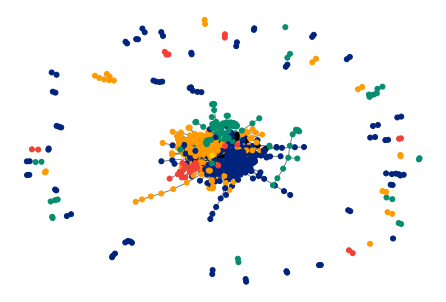

In [19]:
nx.draw_spring(g_h0, node_color=node_color, node_size = 25, edge_color="grey")

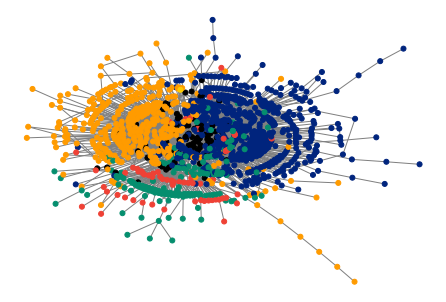

In [20]:
nx.draw_kamada_kawai(g_h0, node_color=node_color, node_size = 25, edge_color="grey")

In [ ]:
geolocator = Nominatim(user_agent="NDA")
notFound = 0
locations_found = {}
count = 0

def do_request(loc, value):
    try:
        return loc.geocode(value,exactly_one=False)
    except GeocoderTimedOut:
        return do_request(loc,value)
        

for x in np.unique(log_small["VoyageFrom"].append(log_small["VoyageTo"])):
    time.sleep(1)
    count+= 1
    location = do_request(geolocator, x)
    if(location==None):
        notFound += 1
        continue
    locations_found[x.replace(" ","").lower()] = location[0]
print("%s locations were not matched with coordinates" % notFound)

In [23]:
print("%s locations were found" % len(locations_found.keys()))

NameError: name 'locations_found' is not defined

In [56]:
# if using a saved object
#pickle.dump(locations_found,open( "locs.p", "wb" ))

In [21]:
locations_found = pickle.load( open( "locs.p", "rb" ))



In [22]:
import json

with open('data/map.geojson') as f:
    seapoints = json.load(f)["features"]


In [23]:
coords = list()

for x in seapoints:
    coords.append([x["geometry"]["coordinates"][1],x["geometry"]["coordinates"][0]])

In [24]:


# for every point find the closest two points and create an edge
edgelist = list()
for x in range(0,len(coords)):
    dist = list()
    index = list()

    for y in range(0,len(coords)):
        if(x==y):
            continue
        if(coords[y][1]< -150 and coords[x][1]> 150 or coords[x][1]< -150 and coords[y][1]> 150):
            # do not cross 180 degrees in the pacific (creates issues for calculating distances and plotting)
            dist.append(9999999999)
        else:
            dist.append(geodesic(coords[x], coords[y]).kilometers)
        index.append(y)

    dist, index = (list(t) for t in zip(*sorted(zip(dist, index))))   
    
    edgelist.append((x,index[0],dist[0]))
    edgelist.append((x,index[1],dist[1]))


In [25]:
# now I can create an additional network
router_network = nx.Graph()
router_network.add_weighted_edges_from(edgelist,weigh="dist")

def return_colour_marker(node):
    if(node["numb"]>1):
        return("black")
    if(node["countries"][0] =="Spain"):
        return("#058e6e")
    if(node["countries"][0] =="United Kingdom"):
        return("#00247d")
    if(node["countries"][0] =="France"):
        return("#EF4135")
    if(node["countries"][0] =="Nederland"):
        return("#FF9B00")
    if(node["countries"][0] =="Sweden"):
        return("#FFCD00")
def return_edge_colour(node1, node2):
    intersec_country = set(node1["countries"]).intersection(set(node2["countries"]))
    if(len(intersec_country)>1):
        return("black")
    if("Spain" in intersec_country ):
        return("#058e6e")
    if( "United Kingdom" in intersec_country):
        return("#00247d")
    if("France" in intersec_country):
        return("#EF4135")
    if("Nederland" in intersec_country ):
        return("#FF9B00")
    if("Sweden" in intersec_country):
        return("#FFCD00")
def find_closest_index(coord,coords):
    dist = list()
    index = list()
    for y in range(0,len(coords)):
        dist.append(geodesic(coord, coords[y]).kilometers)
        index.append(y)
    dist, index = (list(t) for t in zip(*sorted(zip(dist, index))))
    return(index[0])

In [65]:
# finding the closest two coordinates from my harbours to the lets me find the shortest path betwen them
m = folium.Map([0,0],zoom_start=2)

for x in locations_found.keys():
    col = return_colour_marker(node_targeted[x])
    folium.CircleMarker((locations_found[x].latitude,locations_found[x].longitude),
                        radius = 2,color=col).add_to(m)

# go through every single edge in my original graph, 
# check if I have a location for that village
# if no, next pair
# if yes: find nearest point on map
#         get indices, calculate shortest path, 
#         from order, get coordinates, append my villages front and back and then plot on map
k = locations_found.keys()
locations = list(g_h0.edges())
e = g_h0.edges()
e=random.sample(e, len(e))
for x in e:
    if(x[0] in k and x[1] in k):
        first_coords = (locations_found[x[0]].latitude,locations_found[x[0]].longitude)
        second_coords = (locations_found[x[1]].latitude,locations_found[x[1]].longitude)
        first_index = find_closest_index(first_coords, coords)
        second_index = find_closest_index(second_coords, coords)
        try:
            path = nx.shortest_path(router_network,first_index,second_index, weight="dist")
        except NetworkXNoPath:
            continue
        coords_path = [(coords[i][0]+np.random.normal(0,1),coords[i][1]+np.random.normal(0,1)) for i in path]
        coords_path.insert(0,first_coords)
        coords_path.insert(len(coords_path),second_coords)
        col =  return_edge_colour(node_targeted[x[0]], node_targeted[x[1]])
        folium.PolyLine(coords_path, color=col, weight=.5, opacity=0.3).add_to(m)


In [66]:
m.save('map.html')



H1 Important port within network is most likely to be an overlap with the other countries


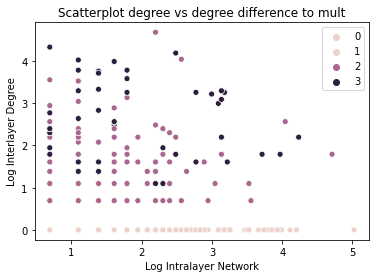

In [26]:
# H1 Important port within network is most likely to be an overlap with the other ports
print("H1 Important port within network is most likely to be an overlap with the other countries")
countries  = layer_dict.keys()

sorted_deg = {}
sub_graphs = {}

for x in countries:
    nodes_in_subgraph  = [n[0] for n in g_h0.nodes(data=True) if n[1]["owner"] == x]
    sub_graph= g_h0.subgraph(nodes_in_subgraph)
    sub_graphs[x] = sub_graph
    sorted_deg[x] = sorted(sub_graph.degree, key=lambda x: x[1], reverse=True)

    
# the top nodes are not as connected as one would have thought.
# idea to show: scatter plot (degree, number of countries connected) and see pattern
# this scatterplot is wrong. i need to get the degrees from the individual network instead 
# of the full network
degrees = list()
col = list()
numbs = list()
all_deg = g_h0.degree
for x in countries:
    # get the degrees
    deg = layer_dict[x].degree
    for y in deg:
        degrees.append(math.log(1+y[1]))
        numbs.append(math.log(1+all_deg[y[0]]-y[1]))
        col.append(node_targeted[y[0]]["numb"])

# what one would expect IF a high degree contributes to a high inter network connectivity
# that the pattern "spreads out" with higher degrees, implying that with more degrees,
# we have a higher absolute difference in inter layer connectivity and hence trade importance
# this does not seem to be the case. 

# potentially a good plot is: number of changes from the degree to non-changes.
# that shows where most of the more connected ports are
ax = sns.scatterplot(degrees,numbs,hue = col)
ax.set(xlabel='Log Intralayer Network', ylabel='Log Interlayer Degree',
      title="Scatterplot degree vs degree difference to mult")
plt.show()






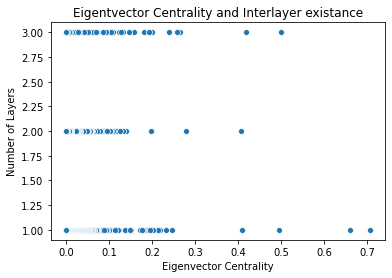

In [27]:
# try to find eigentvector centrality of the different nodes and see if there is a pattern
countries  = layer_dict.keys()

sorted_evc = {}

for x in countries:
    network  = layer_dict[x]
    sorted_evc[x] = sorted(nx.eigenvector_centrality(network).items(), key=lambda x: x[1], reverse=True)
# now I have all the degrees, the next step is to find the top city for every country
# for this, take the first city from every network and check if it is in the other networks
for x in countries:
    top_city = sorted_evc[x][0]

# also doesnt seem to give great results, lets check the scatter plot
#degrees = [x[1] for x in list(nx.degree(g_h0))]
#number_connected = [x[1]["numb"] for x in list(g_h0.nodes(data=True))]
#overall: a pretty shitty plot
#sns.scatterplot(degrees,number_connected)
evc = list()
col = list()
numbs = list()
all_deg = g_h0.degree
#print(sorted_evc["France"])
for x in countries:
    # get the evc for every country
    evcs = sorted_evc[x]
    # for every entry (village) get the evc and the number of inter layer connections 
    for entry in evcs:
        evc.append(entry[1])
        numbs.append(node_targeted[entry[0]]["numb"])
    
ax = sns.scatterplot(evc,numbs)
ax.set(xlabel='Eigenvector Centrality', ylabel='Number of Layers',
      title="Eigentvector Centrality and Interlayer existance")
plt.show()

In [28]:
countries  = layer_dict.keys()
sub_graphs = {}
sorted_evc = {}
# at first I need to create subgraphs from the larger network based on the ports ownership

for x in countries:
    nodes_in_subgraph  = [n[0] for n in g_h0.nodes(data=True) if n[1]["owner"] == x]
    sub_graph= g_h0.subgraph(nodes_in_subgraph)
    sub_graphs[x] = sub_graph
    sorted_evc[x] = sorted(nx.eigenvector_centrality(sub_graph).items(), key=lambda x: x[1], reverse=True)




Text(0.5, 1.0, 'KDE of Eigenvector Centralities by Layers Connected')

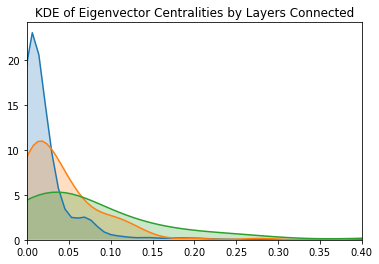

In [29]:
from itertools import compress 
d_n_1 = list(compress(evc,[n==1 for n in numbs]))
d_n_2 = list(compress(evc,[n==2 for n in numbs]))
d_n_3 = list(compress(evc,[n==3 for n in numbs]))

fig, ax = plt.subplots()
for a in [d_n_1,d_n_2,d_n_3]:
    sns.kdeplot(a, ax=ax, shade=True)

ax.set_xlim([0,0.4])
ax.set_title("KDE of Eigenvector Centralities by Layers Connected")

In [30]:
from scipy import stats
print("1 Layer Membership and 2 Layer Membership")
print(stats.ks_2samp(d_n_1, d_n_2))
print("1 Layer Membership and 3 Layer Membership")
print(stats.ks_2samp(d_n_1, d_n_3))
print("2 Layer Membership and 3 Layer Membership")
print(stats.ks_2samp(d_n_2, d_n_3))
print("2 Layer Membership and n Layer Membership")
print(stats.ks_2samp(d_n_1, d_n_2+d_n_3))
print("One can hereby conclude that they have significantly different memberships and"+
      "important harbours are more likely to have a connection to another layer")

1 Layer Membership and 2 Layer Membership
Ks_2sampResult(statistic=0.2928894114734823, pvalue=1.9726515976259407e-09)
1 Layer Membership and 3 Layer Membership
Ks_2sampResult(statistic=0.44117725931885227, pvalue=1.2086953660173094e-10)
2 Layer Membership and 3 Layer Membership
Ks_2sampResult(statistic=0.21025641025641026, pvalue=0.0450690453849204)
2 Layer Membership and n Layer Membership
Ks_2sampResult(statistic=0.337828682728543, pvalue=2.220446049250313e-16)
One can hereby conclude that they have significantly different memberships andimportant harbours are more likely to have a connection to another layer


In [31]:
print("T-test 1 and 2 layer membership")
print(stats.ttest_ind(d_n_1,d_n_2))
print("T-test 1 and 3 layer membership")
print(stats.ttest_ind(d_n_1,d_n_3))
print("T-test 2 and 3 layer membership")
print(stats.ttest_ind(d_n_2,d_n_3))

T-test 1 and 2 layer membership
Ttest_indResult(statistic=-4.64208665253438, pvalue=3.779423801752395e-06)
T-test 1 and 3 layer membership
Ttest_indResult(statistic=-9.640585014833482, pvalue=2.7203123923257734e-21)
T-test 2 and 3 layer membership
Ttest_indResult(statistic=-3.651372665293979, pvalue=0.0003380250764606671)


In [32]:
# H2 Each country has a local hub, which dominates trade in every network
# how can I measure the backbone
# this could be the port with 
# 1. the highest eigenvector centrality
# 2. the highest degree
print("H2 Each country has local hubs, which dominates trade in every network")
countries  = layer_dict.keys()

sorted_deg = {}
sub_graphs = {}

for x in countries:
    nodes_in_subgraph  = [n[0] for n in g_h0.nodes(data=True) if n[1]["owner"] == x]
    sub_graph= g_h0.subgraph(nodes_in_subgraph)
    sub_graphs[x] = sub_graph
    sorted_deg[x] = sorted(sub_graph.degree, key=lambda x: x[1], reverse=True)


for x in countries:
    # get the evc for every country
    evcs = sorted_evc[x]
    degs = sorted_deg[x]



H2 Each country has local hubs, which dominates trade in every network


France
Number of Nodes before removal of dominant ports:
56
after removal of:
{'rochefort', 'brest'}
There are 30 nodes left
A reduction to 0.4642857142857143 percent
---------------

Nederland
Number of Nodes before removal of dominant ports:
378
after removal of:
{'batavia', 'texel'}
There are 335 nodes left
A reduction to 0.11375661375661372 percent
---------------

Spain
Number of Nodes before removal of dominant ports:
127
after removal of:
{'montevideo', 'cádiz'}
There are 55 nodes left
A reduction to 0.5669291338582677 percent
---------------

United Kingdom
Number of Nodes before removal of dominant ports:
574
after removal of:
{'spithead', 'plymouth'}
There are 489 nodes left
A reduction to 0.1480836236933798 percent
---------------



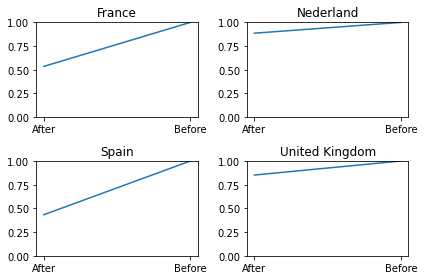

In [35]:
# what happens to the avg shortest path in every network 
# when we remove the top nodes from every network
fig, ax = plt.subplots(nrows=2, ncols=2)
axl = [j for sub in ax for j in sub]
k = list(layer_dict.keys())
k.remove("Sweden")


for x in range(len(k)):
    # get the evc for every country
    print(k[x])
    
    evcs = [i[0] for i in sorted_evc[k[x]][:2]]
    sub_graph = sub_graphs[k[x]]
    print("Number of Nodes before removal of dominant ports:")
    # just select the largest connected component
    nodes_in_lcc = sorted(nx.connected_components(sub_graph), key=len, reverse=True)[0]
    lcc = sub_graph.subgraph(nodes_in_lcc)
    
    before = len(lcc.nodes)
    print(before)
    print("after removal of:")
    print(set(evcs))
    # remove the top central nodes from the lcc
    nodes_in_lcc = nodes_in_lcc - set(evcs)
    # create a subgraph based on these remaining nodes
    lcc = sub_graph.subgraph(nodes_in_lcc)
    # select the largest connected component
    nodes_in_lcc = sorted(nx.connected_components(lcc), key=len, reverse=True)[0]
    # subgraph the largect connected component
    lcc = sub_graph.subgraph(nodes_in_lcc)
    
    if(nx.is_connected(lcc)):
        after = len(lcc.nodes)
        print("There are %s nodes left" % after)
        reduction = 1-float(after)/before
        print("A reduction to %s percent" % reduction)
        sns.lineplot(x=["After","Before"],y=[float(after)/before,before/float(before)], ax= axl[x])
        axl[x].set_ylim([0,1])
        axl[x].set_title(k[x])
    else:
        print("not connected anymore")
    print("---------------")
    print("")
plt.tight_layout()
    


France
Average Shortest Path before removal of dominant ports:
2.9922077922077923
after removal of:
{'rochefort', 'brest'}
The average shortest path is:
4.225287356321839
An increase of 0.4120969029374202 percent
--------

Nederland
Average Shortest Path before removal of dominant ports:
3.561576354679803
after removal of:
{'batavia', 'texel'}
The average shortest path is:
4.144945929037448
An increase of 0.16379533000636504 percent
--------

Spain
Average Shortest Path before removal of dominant ports:
3.188476440444944
after removal of:
{'montevideo', 'cádiz'}
The average shortest path is:
3.6585858585858584
An increase of 0.14744014168576114 percent
--------

United Kingdom
Average Shortest Path before removal of dominant ports:
3.5519577260095714
after removal of:
{'spithead', 'plymouth'}
The average shortest path is:
3.845586509772369
An increase of 0.08266674504954574 percent
--------



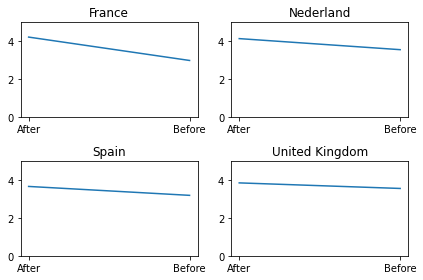

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axl = [j for sub in ax for j in sub]
k = list(layer_dict.keys())
k.remove("Sweden")


for x in range(len(k)):
    # get the evc for every country
    print(k[x])
    before = 0
    evcs = [i[0] for i in sorted_evc[k[x]][:2]]
    sub_graph = sub_graphs[k[x]]    
    print("Average Shortest Path before removal of dominant ports:")
    # just select the largest connected component
    nodes_in_lcc = sorted(nx.connected_components(sub_graph), key=len, reverse=True)[0]
    lcc = sub_graph.subgraph(nodes_in_lcc)
    before = nx.average_shortest_path_length(lcc)
    print(before)
    print("after removal of:")
    print(set(evcs))
    # remove the top central nodes from the lcc
    nodes_in_lcc = nodes_in_lcc - set(evcs)
    # create a subgraph based on these remaining nodes
    lcc = sub_graph.subgraph(nodes_in_lcc)
    # select the largest connected component
    nodes_in_lcc = sorted(nx.connected_components(lcc), key=len, reverse=True)[0]
    # subgraph the largect connected component
    lcc = sub_graph.subgraph(nodes_in_lcc)
    
    if(nx.is_connected(lcc)):
        after = nx.average_shortest_path_length(lcc)
        print("The average shortest path is:")
        print(after)
        increase = float(after)/before-1
        print("An increase of %s percent" %increase)
        sns.lineplot(x=["Before","After"],y=[before,after], ax= axl[x])
        axl[x].set_ylim([0,5])
        axl[x].set_title(k[x])

    else:
        print("not connected anymore")
    print("--------")
    print("")
plt.tight_layout()

In [ ]:
# H3 The median distance of the countries vary greatly.
print("H3 The travel distances of the countries vary greatly.")
k = locations_found.keys()
locations = list(g_h0.edges())
dist_dict = {}

for y in countries:
    nodes_in_subgraph  = [n[0] for n in g_h0.nodes(data=True) if n[1]["owner"] == y]
    sub_graph= g_h0.subgraph(nodes_in_subgraph)
    e = sub_graph.edges()
    country_dist = list()
    for x in e:
        if(x[0] in k and x[1] in k):
            first_coords = (locations_found[x[0]].latitude,locations_found[x[0]].longitude)
            second_coords = (locations_found[x[1]].latitude,locations_found[x[1]].longitude)
            first_index = find_closest_index(first_coords, coords)
            second_index = find_closest_index(second_coords, coords)
            try:
                path = nx.shortest_path(router_network,first_index,second_index, weight="dist")
            except NetworkXNoPath:
                continue
            coords_path = [(coords[i][0]+np.random.normal(0,1),coords[i][1]+np.random.normal(0,1)) for i in path]
            coords_path.insert(0,first_coords)
            coords_path.insert(len(coords_path),second_coords)
            this_dist = 0
            for i in range(0,len(coords_path)-1):
                this_dist += geodesic(coords_path[i], coords_path[i+1]).kilometers
            country_dist.append(this_dist)
    dist_dict[y] = country_dist
print("done")
            

Country: France
Median distance: 10624.009077954557
Mean Distance: 9147.715762391614
------------

Country: Nederland
Median distance: 13031.3221707715
Mean Distance: 14523.642936879405
------------

Country: Spain
Median distance: 13194.2026953699
Mean Distance: 12956.841921908648
------------

Country: United Kingdom
Median distance: 12593.021943984826
Mean Distance: 13266.764958229805
------------



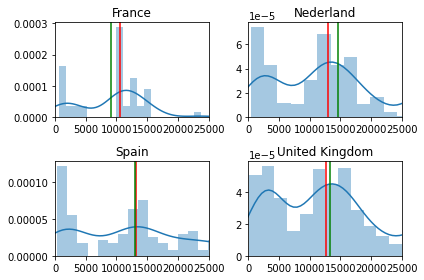

In [62]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axl = [j for sub in ax for j in sub]
k = list(dist_dict.keys())
k.remove("Sweden")

for x in range(0,len(k)):
    print("Country: %s" % k[x])
    print("Median distance: %s" % np.median(dist_dict[k[x]]))
    print("Mean Distance: %s" % np.mean(dist_dict[k[x]]))
    print("------------")
    print("")
    
    sns.distplot(dist_dict[k[x]], ax= axl[x], bins = 20, norm_hist=True)
    axl[x].set_xlim([0,25000])
    axl[x].axvline(x=np.median(dist_dict[k[x]]), color="r")
    axl[x].axvline(x=np.mean(dist_dict[k[x]]), color="g")
    axl[x].set_title(k[x])
plt.tight_layout()
# from this it is possible to see that most of them are actually bimodal 

In [64]:
# t test of distances
c = list(dist_dict.keys())
c.remove("Sweden")
for i in c:
    for j in c:
        if(i==j):
            continue
        print("%s and %s" % (i,j))

        
        print(stats.ttest_ind(dist_dict[i],dist_dict[j]))
        print("---------")

France and Nederland
Ttest_indResult(statistic=-3.605364866382243, pvalue=0.0003421604998262061)
---------
France and Spain
Ttest_indResult(statistic=-2.626422335812921, pvalue=0.009328719719373017)
---------
France and United Kingdom
Ttest_indResult(statistic=-3.0652644370579503, pvalue=0.0022675004700117704)
---------
Nederland and France
Ttest_indResult(statistic=3.605364866382243, pvalue=0.0003421604998262061)
---------
Nederland and Spain
Ttest_indResult(statistic=1.6420179590923372, pvalue=0.10110167666890521)
---------
Nederland and United Kingdom
Ttest_indResult(statistic=2.102673146374944, pvalue=0.0357317050101665)
---------
Spain and France
Ttest_indResult(statistic=2.626422335812921, pvalue=0.009328719719373017)
---------
Spain and Nederland
Ttest_indResult(statistic=-1.6420179590923372, pvalue=0.10110167666890521)
---------
Spain and United Kingdom
Ttest_indResult(statistic=-0.3610478346718042, pvalue=0.7181682912693439)
---------
United Kingdom and France
Ttest_indResult(